In [1]:
import pandas as pd
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
import numpy as np
from hyperopt import Trials, tpe, fmin
import warnings
from imblearn.under_sampling import RandomUnderSampler
from joblib import load
import statistics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, precision_score, recall_score
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../code/output.csv",index_col=False)

In [3]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

In [4]:
selected_columns=["locus tag","essential","DNA","protein sequence"]
Xs= df.drop(columns=selected_columns)
y=df["essential"]

In [5]:
from sklearn.model_selection import KFold

model_Sta = load('../../model/XGB_model_Sta.joblib')
scores_sta_ac = []
scores_sta_f1 = []
scores_sta_auc = []
scores_sta_precision = []
scores_sta_recall = []
feature_sta = ['GC_Content', 'CAI', 'R', 'D', 'E', 'S', 'nSE2', 'nSE3', 'nGE3']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(Xs):
    X_train_fold, X_test_fold = Xs.iloc[train_index], Xs.iloc[test_index]
    y_train_fold, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_fold, y_train_fold)
    model_Sta.fit(X_train_undersampled[feature_sta], y_train_undersampled)
    y_predict = model_Sta.predict(X_test_fold[feature_sta])
    acc=accuracy_score(y_test, y_predict)
    scores_sta_ac.append(acc)
    auc = roc_auc_score(y_test,y_predict)
    scores_sta_auc.append(auc)
    f1 = f1_score(y_test,y_predict)
    scores_sta_f1.append(f1)
    precision = precision_score(y_test,y_predict)
    scores_sta_precision.append(precision)
    recall = recall_score(y_test,y_predict)
    scores_sta_recall.append(recall)

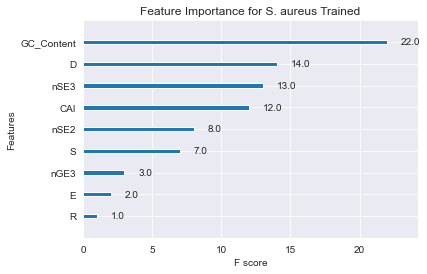

In [9]:
from matplotlib import pyplot as plt
from xgboost import plot_importance
plot_importance(model_Sta)
plt.title("Feature Importance for S. aureus Trained")
plt.savefig("../s", bbox_inches='tight')
plt.show()

<Figure size 2160x2160 with 0 Axes>

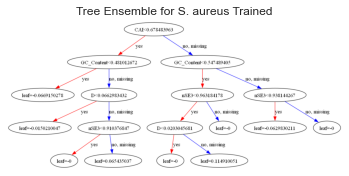

In [8]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'D:/Graphviz-10.0.1-win64/bin'

plt.figure(figsize=(30,30)) 
plot_tree(model_Sta, num_trees=1,fontsize = 20)
plt.title("Tree Ensemble for S. aureus Trained")
plt.savefig("../s_tree",dpi=1000)
plt.show()

In [6]:
print(scores_sta_ac)
print(statistics.mean(scores_sta_ac),statistics.variance(scores_sta_ac))

[0.5519323671497585, 0.5531400966183575, 0.6219806763285024, 0.5205314009661836, 0.5840386940749698]
0.5663246470275544 0.001472343133689187


In [9]:
import csv
def generateString(scores):
    mean_score = round(np.mean(scores),4)
    var_score = round(np.var(scores),4)
    return f'{mean_score}±{var_score}'
with open('resultEcoli.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Type','ACC','AUC','F1','Precision', 'Recall'])
    writer.writerow(['Sta',generateString(scores_sta_ac),generateString(scores_sta_auc),generateString(scores_sta_f1),generateString(scores_sta_precision),generateString(scores_sta_recall)])